In [1]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

# Auto reload of library
%reload_ext autoreload
%autoreload 2

from import_KK import *
DeviceStrategy_CPU()
from preprocessing_KK import *
from description_KK import *
from algorithm_KK import *
from evaluation_KK import *
from visualization_KK import *

JAVA is in the system path?:  False
JAVA is in the system path?:  Adding...


# Data Preprocessing

In [32]:
!pip install -U pip setuptools wheel
!pip install -U spacy
# !pip install -U 'spacy[cuda-autodetect]'
!python -m spacy download en_core_web_sm
!python -m spacy download ko_core_news_sm
!python -m spacy download en_core_web_trf
!python -m spacy download ko_core_news_lg
!pip install kss
!pip install soynlp

     ---------------------------------------- 0.0/416.8 kB ? eta -:--:--
     ------------------------------------  409.6/416.8 kB 12.9 MB/s eta 0:00:01
     -------------------------------------- 416.8/416.8 kB 8.6 MB/s eta 0:00:00


In [70]:
import re
import string
import kss    # 문장분리
import nltk
nltk.download('stopwords')
nltk.download('punkt')

## 영어
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS as sw_eng
## 한국어
from kss import split_sentences
from spacy.lang.ko.stop_words import STOP_WORDS as sw_kor
from soynlp.normalizer import *
from soynlp.word import WordExtractor
from soynlp.noun import LRNounExtractor, LRNounExtractor_v2, NewsNounExtractor
from soynlp.tokenizer import LTokenizer

### Date and Author: 20230929, Kyungwon Kim ### 
### 하위의 모든 데이터 결합하여 출력
def get_data_from_path(folder_location, axis='row'):
    # path_folder 하위의 모든 폴더위치와 내부 file 출력
    df = pd.DataFrame()
    print('Getting data from', len(os.listdir(folder_location)), 'folders...')
    for (path, dir, files) in os.walk(folder_location):
        for file in tqdm(files):
            path_file = os.path.join(path, file)

            ## 데이터 로딩
            if path_file.split('.')[1] == 'xlsx':
                df_sub = pd.read_excel(path_file)
            elif path_file.split('.')[1] == 'csv':
                df_sub = pd.read_csv(path_file)
            
            ## 정리
            if axis == 'col':
                df = pd.concat([df, df_sub], axis=1)
            elif axis == 'row':
                df = pd.concat([df, df_sub], axis=0)
                
    return df

def text_preprocessor(text, del_bracket_content=False):
    # 한글 맞춤법과 띄어쓰기 체크 (PyKoSpacing, Py-Hanspell)
    # html 태그 제거하기
    text_new = re.sub(r'<[^>]+>', '', text)
    # 괄호와 내부문자 제거하기
    if del_bracket_content:
        text_new = re.sub(r'\([^)]*\)', '', text_new)
        text_new = re.sub(r'\[[^)]*\]', '', text_new)
        text_new = re.sub(r'\<[^)]*\>', '', text_new)
        text_new = re.sub(r'\{[^)]*\}', '', text_new)
    # 영어(소문자화), 한글, 숫자만 남기고 제거하기
    text_new = re.sub('[^ A-Za-z0-9가-힣]', '', text_new.lower())
    # 한글 자음과 모음 제거하기
    text_new = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)', '', text_new)
    # 숫자 제거하기
    text_new = re.sub(r'\d+', '', text_new)
    # 문장구두점 및 양쪽공백 제거하기
    translator = str.maketrans('', '', string.punctuation)
    text_new = text_new.strip().translate(translator)
    # 2개 이상의 반복글자 줄이기
    text_new = ' '.join([emoticon_normalize(word, num_repeats=2) for word in text_new.split(' ')])
    text_new = ' '.join([repeat_normalize(word, num_repeats=2) for word in text_new.split(' ')])
    # 영어 및 한글 stopwords 제거하기
    stop_words_eng = set(stopwords.words('english'))
    stop_words_kor = ['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', 
 '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', 
 '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', 
 '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다',
 '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다',
 '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도',
 '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만',
 '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다',
 '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서',
 '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇',
 '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로',
 '반대로 말하자면', '이와 반대로', '바꾸어서 말하면', '바꾸어서 한다면', '만약', '그렇지않으면', '까악', '툭', '딱', '삐걱거리다',
 '보드득', '비걱거리다', '꽈당', '응당', '해야한다', '에 가서', '각', '각각', '여러분', '각종', '각자', '제각기', '하도록하다',
 '와', '과', '그러므로', '그래서', '고로', '한 까닭에', '하기 때문에', '거니와', '이지만', '대하여', '관하여', '관한', '과연',
 '실로', '아니나다를가', '생각한대로', '진짜로', '한적이있다', '하곤하였다', '하', '하하', '허허', '아하', '거바', '와', '오',
 '왜', '어째서', '무엇때문에', '어찌', '하겠는가', '무슨', '어디', '어느곳', '더군다나', '하물며', '더욱이는', '어느때', '언제',
 '야', '이봐', '어이', '여보시오', '흐흐', '흥', '휴', '헉헉', '헐떡헐떡', '영차', '여차', '어기여차', '끙끙', '아야', '앗',
 '아야', '콸콸', '졸졸', '좍좍', '뚝뚝', '주룩주룩', '솨', '우르르', '그래도', '또', '그리고', '바꾸어말하면', '바꾸어말하자면',
 '혹은', '혹시', '답다', '및', '그에 따르는', '때가 되어', '즉', '지든지', '설령', '가령', '하더라도', '할지라도', '일지라도',
 '지든지', '몇', '거의', '하마터면', '인젠', '이젠', '된바에야', '된이상', '만큼어찌됏든', '그위에', '게다가', '점에서 보아',
 '비추어 보아', '고려하면', '하게될것이다', '일것이다', '비교적', '좀', '보다더', '비하면', '시키다', '하게하다', '할만하다',
 '의해서', '연이서', '이어서', '잇따라', '뒤따라', '뒤이어', '결국', '의지하여', '기대여', '통하여', '자마자', '더욱더',
 '불구하고', '얼마든지', '마음대로', '주저하지 않고', '곧', '즉시', '바로', '당장', '하자마자', '밖에 안된다', '하면된다',
 '그래', '그렇지', '요컨대', '다시 말하자면', '바꿔 말하면', '즉', '구체적으로', '말하자면', '시작하여', '시초에', '이상', '허',
 '헉', '허걱', '바와같이', '해도좋다', '해도된다', '게다가', '더구나', '하물며', '와르르', '팍', '퍽', '펄렁', '동안', '이래',
 '하고있었다', '이었다', '에서', '로부터', '까지', '예하면', '했어요', '해요', '함께', '같이', '더불어', '마저', '마저도',
 '양자', '모두', '습니다', '가까스로', '하려고하다', '즈음하여', '다른', '다른 방면으로', '해봐요', '습니까', '했어요',
 '말할것도 없고', '무릎쓰고', '개의치않고', '하는것만 못하다', '하는것이 낫다', '매', '매번', '들', '모', '어느것', '어느',
 '로써', '갖고말하자면', '어디', '어느쪽', '어느것', '어느해', '어느 년도', '라 해도', '언젠가', '어떤것', '어느것', '저기',
 '저쪽', '저것', '그때', '그럼', '그러면', '요만한걸', '그래', '그때', '저것만큼', '그저', '이르기까지', '할 줄 안다',
 '할 힘이 있다', '너', '너희', '당신', '어찌', '설마', '차라리', '할지언정', '할지라도', '할망정', '할지언정', '구토하다',
 '게우다', '토하다', '메쓰겁다', '옆사람', '퉤', '쳇', '의거하여', '근거하여', '의해', '따라', '힘입어', '그', '다음', '버금',
 '두번째로', '기타', '첫번째로', '나머지는', '그중에서', '견지에서', '형식으로 쓰여', '입장에서', '위해서', '단지', '의해되다',
 '하도록시키다', '뿐만아니라', '반대로', '전후', '전자', '앞의것', '잠시', '잠깐', '하면서', '그렇지만', '다음에', '그러한즉',
 '그런즉', '남들', '아무거나', '어찌하든지', '같다', '비슷하다', '예컨대', '이럴정도로', '어떻게', '만약', '만일',
 '위에서 서술한바와같이', '인 듯하다', '하지 않는다면', '만약에', '무엇', '무슨', '어느', '어떤', '아래윗', '조차', '한데',
 '그럼에도 불구하고', '여전히', '심지어', '까지도', '조차도', '하지 않도록', '않기 위하여', '때', '시각', '무렵', '시간',
 '동안', '어때', '어떠한', '하여금', '네', '예', '우선', '누구', '누가 알겠는가', '아무도', '줄은모른다', '줄은 몰랏다',
 '하는 김에', '겸사겸사', '하는바', '그런 까닭에', '한 이유는', '그러니', '그러니까', '때문에', '그', '너희', '그들', '너희들',
 '타인', '것', '것들', '너', '위하여', '공동으로', '동시에', '하기 위하여', '어찌하여', '무엇때문에', '붕붕', '윙윙', '나',
 '우리', '엉엉', '휘익', '윙윙', '오호', '아하', '어쨋든', '만 못하다하기보다는', '차라리', '하는 편이 낫다', '흐흐', '놀라다',
 '상대적으로 말하자면', '마치', '아니라면', '쉿', '그렇지 않으면', '그렇지 않다면', '안 그러면', '아니었다면', '하든지', '아니면',
 '이라면', '좋아', '알았어', '하는것도', '그만이다', '어쩔수 없다', '하나', '일', '일반적으로', '일단', '한켠으로는', '오자마자',
 '이렇게되면', '이와같다면', '전부', '한마디', '한항목', '근거로', '하기에', '아울러', '하지 않도록', '않기 위해서', '이르기까지',
 '이 되다', '로 인하여', '까닭으로', '이유만으로', '이로 인하여', '그래서', '이 때문에', '그러므로', '그런 까닭에', '알 수 있다',
 '결론을 낼 수 있다', '으로 인하여', '있다', '어떤것', '관계가 있다', '관련이 있다', '연관되다', '어떤것들', '에 대해', '이리하여',
 '그리하여', '여부', '하기보다는', '하느니', '하면 할수록', '운운', '이러이러하다', '하구나', '하도다', '다시말하면', '다음으로',
 '에 있다', '에 달려 있다', '우리', '우리들', '오히려', '하기는한데', '어떻게', '어떻해', '어찌됏어', '어때', '어째서', '본대로',
 '자', '이', '이쪽', '여기', '이것', '이번', '이렇게말하자면', '이런', '이러한', '이와 같은', '요만큼', '요만한 것',
 '얼마 안 되는 것', '이만큼', '이 정도의', '이렇게 많은 것', '이와 같다', '이때', '이렇구나', '것과 같이', '끼익', '삐걱', '따위',
 '와 같은 사람들', '부류의 사람들', '왜냐하면', '중의하나', '오직', '오로지', '에 한하다', '하기만 하면', '도착하다',
 '까지 미치다', '도달하다', '정도에 이르다', '할 지경이다', '결과에 이르다', '관해서는', '여러분', '하고 있다', '한 후', '혼자',
 '자기', '자기집', '자신', '우에 종합한것과같이', '총적으로 보면', '총적으로 말하면', '총적으로', '대로 하다', '으로서', '참',
 '그만이다', '할 따름이다', '쿵', '탕탕', '쾅쾅', '둥둥', '봐', '봐라', '아이야', '아니', '와아', '응', '아이', '참나', '년',
 '월', '일', '령', '영', '일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '이천육', '이천칠', '이천팔', '이천구',
 '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '령', '영']
    text_new = ' '.join([word for word in text_new.split(' ') if word not in stop_words_eng])
    text_new = ' '.join([word for word in text_new.split(' ') if word not in stop_words_kor])
    text_new = ' '.join([word for word in text_new.split(' ') if word not in sw_eng])
    text_new = ' '.join([word for word in text_new.split(' ') if word not in sw_kor])
   
    return text_new

def preprocessing_nounextract(df_series):
    # 단어 추출기
    ## cohesion/branching entropy/accessor variety값이 큰 경우 하나의 단어일 가능성 높음
    word_extractor = WordExtractor()
    word_extractor.train(list(df_series.values))
    word_score = word_extractor.extract()
    ## cohesion_forward*right_branching_entropy 로 scoring
    words = {word:score.cohesion_forward * math.exp(score.right_branching_entropy) for word, score in word_score.items()
             if len(word) != 1}
    nouns_WE = sorted(words.items(), key=lambda x:x[1], reverse=True)

    # 단어추출기
    noun_extractor = LRNounExtractor_v2(verbose=False, extract_compound=True)
    noun_extractor.train(list(df_series.values))
    noun_score = noun_extractor.extract()
    ## unique 단어들로 필터
    unique_nouns = list(set([words for word_tuple in noun_extractor._compounds_components.values() for words in word_tuple]))
    nouns = {noun:noun_score[noun] for noun in unique_nouns if noun in noun_score.keys()}
    ## 빈도수*명사점수 로 scoring
    nouns = {noun:score.frequency * score.score for noun, score in nouns.items() if len(noun) != 1}
    nouns_LRE = sorted(nouns.items(), key=lambda x:x[1], reverse=True)
    
    # 단어추출기
    noun_extractor = NewsNounExtractor(verbose=False)
    noun_extractor.train(list(df_series.values))
    noun_score = noun_extractor.extract()
    ## 빈도수*명사점수 로 scoring
    nouns = {noun:score.frequency * score.score for noun, score in noun_score.items() if len(noun) != 1}
    nouns_NE = sorted(nouns.items(), key=lambda x:x[1], reverse=True)
    
    # 정리: 3가지 추출기에서 공통으로 추출된 단어들의 score들을 더하여 내림차순
    nouns_unique = list(set([word for word_result in [nouns_WE, nouns_LRE, nouns_NE] for word, _ in word_result]))
    nouns_intersection = []
    for noun in nouns_unique:
        if (noun in noun in dict(nouns_WE).keys()) and (noun in noun in dict(nouns_LRE).keys()) and (noun in noun in dict(nouns_NE).keys()):
            nouns_intersection.append((noun, int(dict(nouns_WE)[noun] + dict(nouns_LRE)[noun] + dict(nouns_NE)[noun])))
    nouns_final = sorted(dict(nouns_intersection).items(), key=lambda x:x[1], reverse=True)

    return nouns_final


#     # 문장 분리하기
#     if split_sentences:
#         if text_new.isalpha():
#             text_new = sent_tokenize(text_new)
#         else:
#             text_new = split_sentences(text_new)
# 감정 분석시 동사 형용사도 반영 
# KOMORAN은 타 형태소 분석기와 달리 여러 어절을 하나의 품사로 분석가능하여 고유명사(영화 제목, 음식점명 등)을 더욱 정확하게 분석이 가능하다

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
# 하이퍼파라미터
FOLDER_LOCATION = os.path.join(os.getcwd(), 'Data', '빅카인즈')
IMAGE_LOCATION = 'wordcloud_ageism.png'

# 데이터로딩
df_news = get_data_from_path(FOLDER_LOCATION)
df = df_news.copy()
## 날짜 인식
df['일자'] = pd.to_datetime(df['일자'].astype(str))
## 중복 처리
df.drop_duplicates(inplace=True, ignore_index=True)
## 전처리
df['제목'] = df['제목'].apply(lambda x: text_preprocessor(x, del_bracket_content=False))

Getting data from 39 folders...


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


2013
training was done. used memory 6.113 Gbory 6.004 Gb
all cohesion probabilities was computed. # words = 27122
all branching entropies was computed # words = 54949
all accessor variety was computed # words = 54949
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 32895
_noun_scores_ 6688
after postprocessing 4618


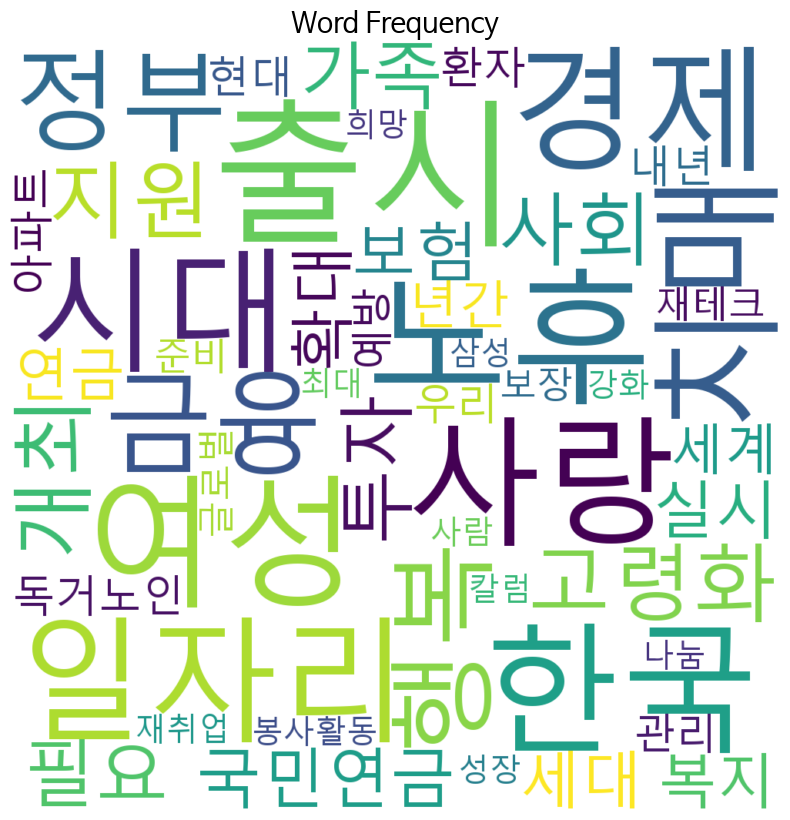

2014
training was done. used memory 6.148 Gbory 6.126 Gb
all cohesion probabilities was computed. # words = 30505
all branching entropies was computed # words = 57260
all accessor variety was computed # words = 57260
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 36599
_noun_scores_ 7528
after postprocessing 5208


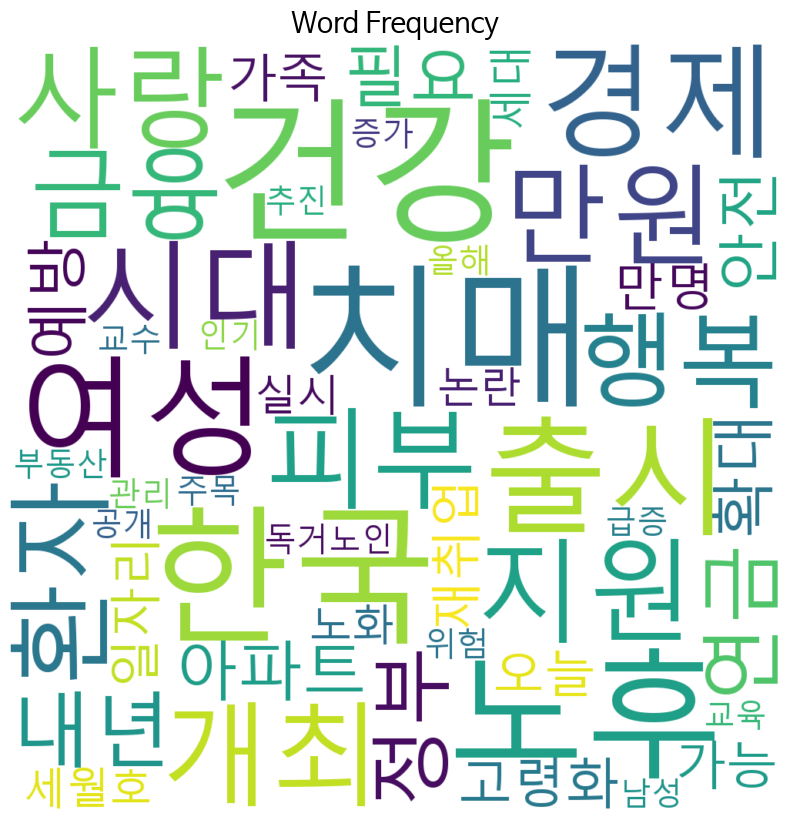

2015
training was done. used memory 6.182 Gbory 6.149 Gb
all cohesion probabilities was computed. # words = 38378
all branching entropies was computed # words = 74857
all accessor variety was computed # words = 74857
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 45324
_noun_scores_ 9047
after postprocessing 6251


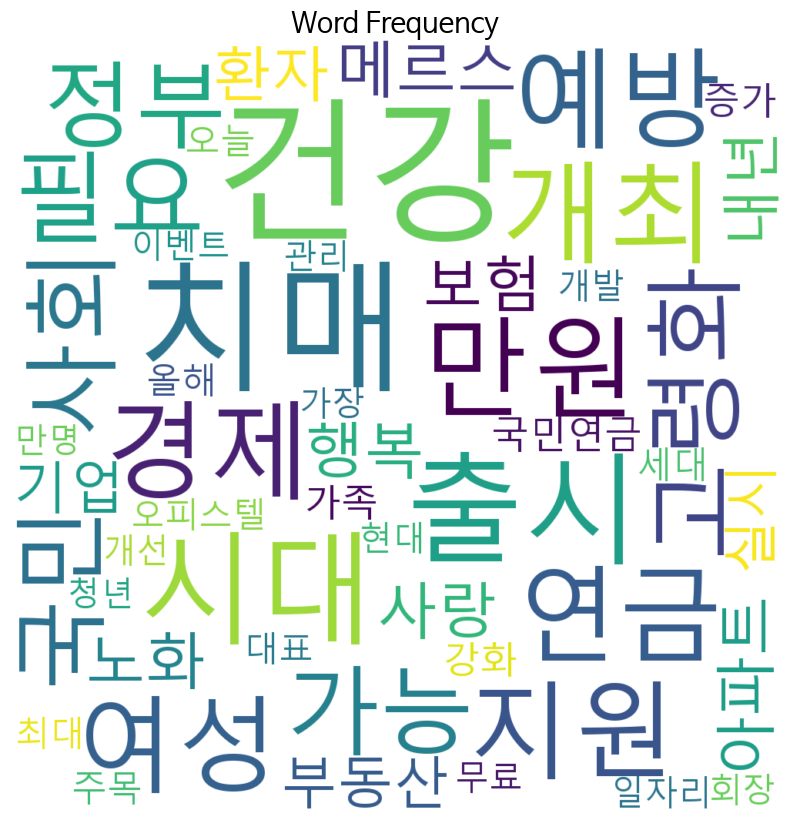

2016
training was done. used memory 6.184 Gbory 6.178 Gb
all cohesion probabilities was computed. # words = 31719
all branching entropies was computed # words = 48284
all accessor variety was computed # words = 48284
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 37204
_noun_scores_ 7748
after postprocessing 5378


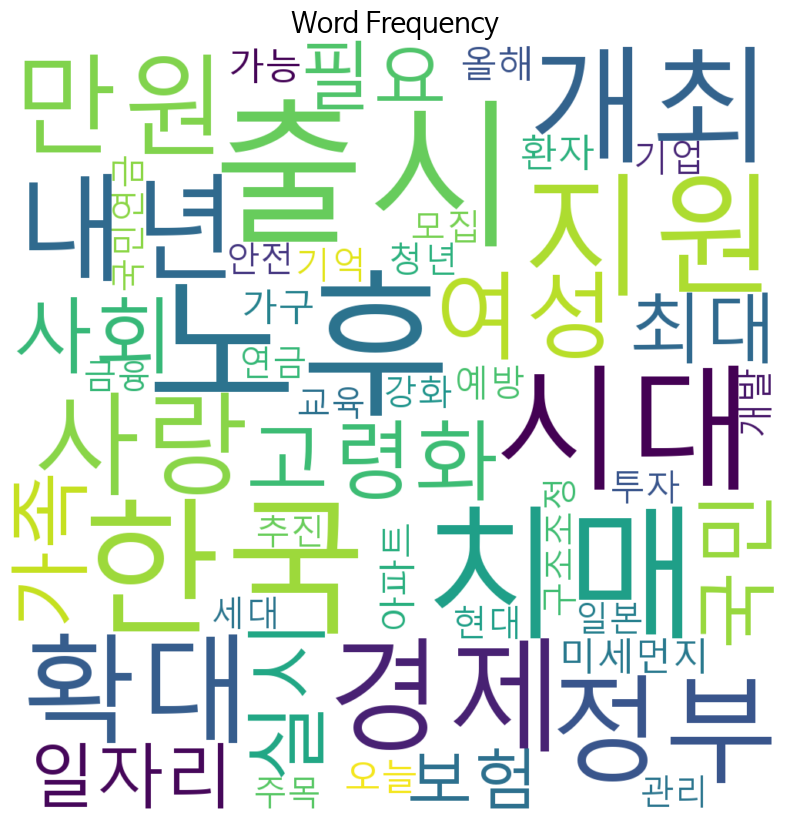

2017
training was done. used memory 6.187 Gbory 6.180 Gb
all cohesion probabilities was computed. # words = 31765
all branching entropies was computed # words = 48317
all accessor variety was computed # words = 48317
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 37718
_noun_scores_ 7937
after postprocessing 5487


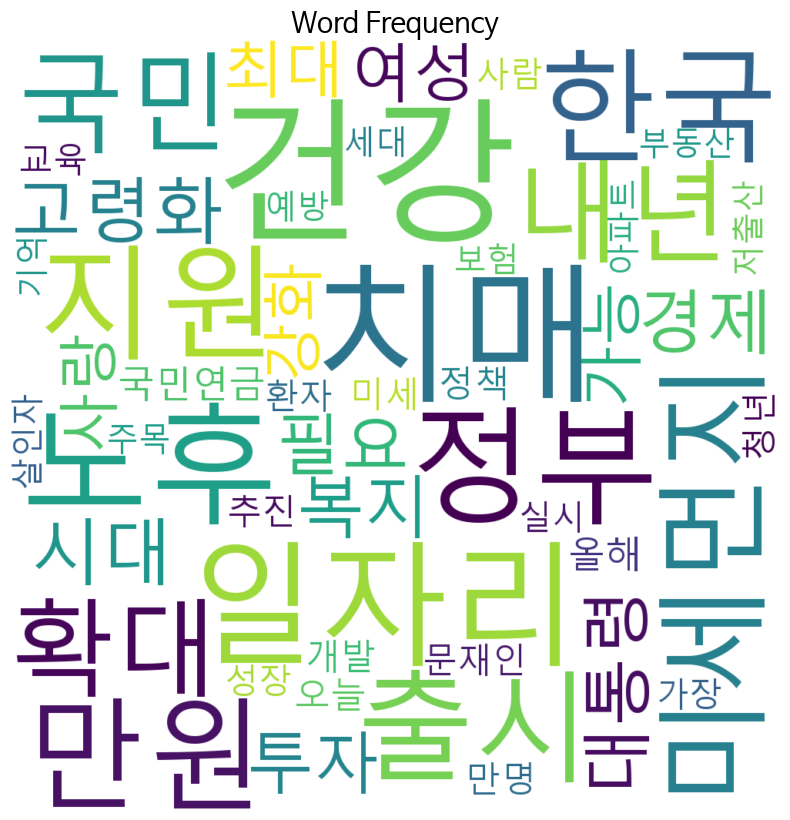

2018
training was done. used memory 6.192 Gbory 6.185 Gb
all cohesion probabilities was computed. # words = 33160
all branching entropies was computed # words = 56549
all accessor variety was computed # words = 56549
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 39547
_noun_scores_ 8203
after postprocessing 5623


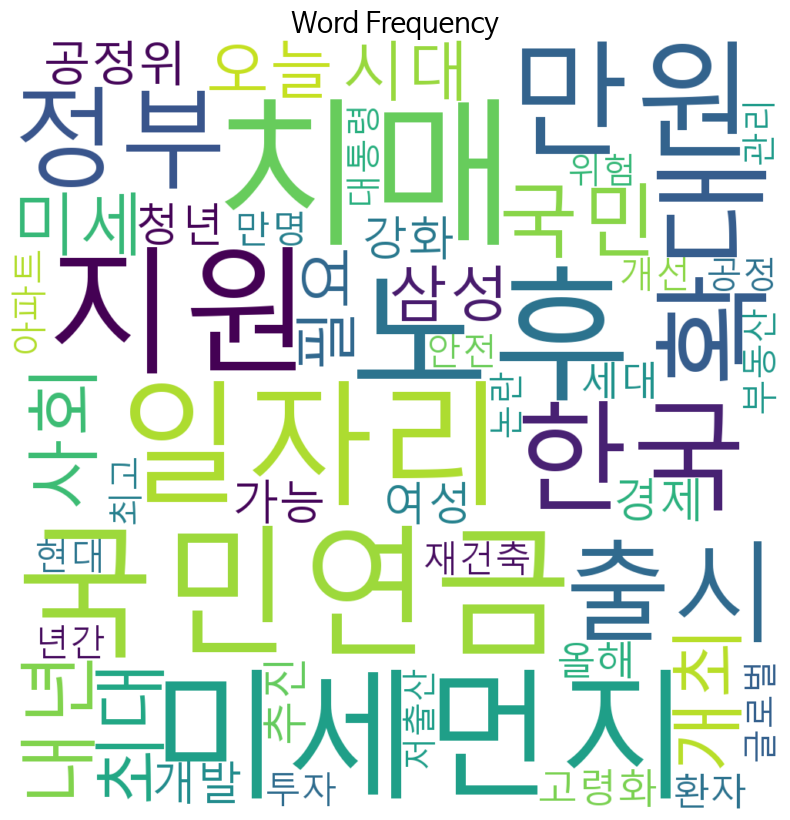

2019
training was done. used memory 6.191 Gbory 6.184 Gb
all cohesion probabilities was computed. # words = 35690
all branching entropies was computed # words = 58898
all accessor variety was computed # words = 58898
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 42277
_noun_scores_ 8930
after postprocessing 6114


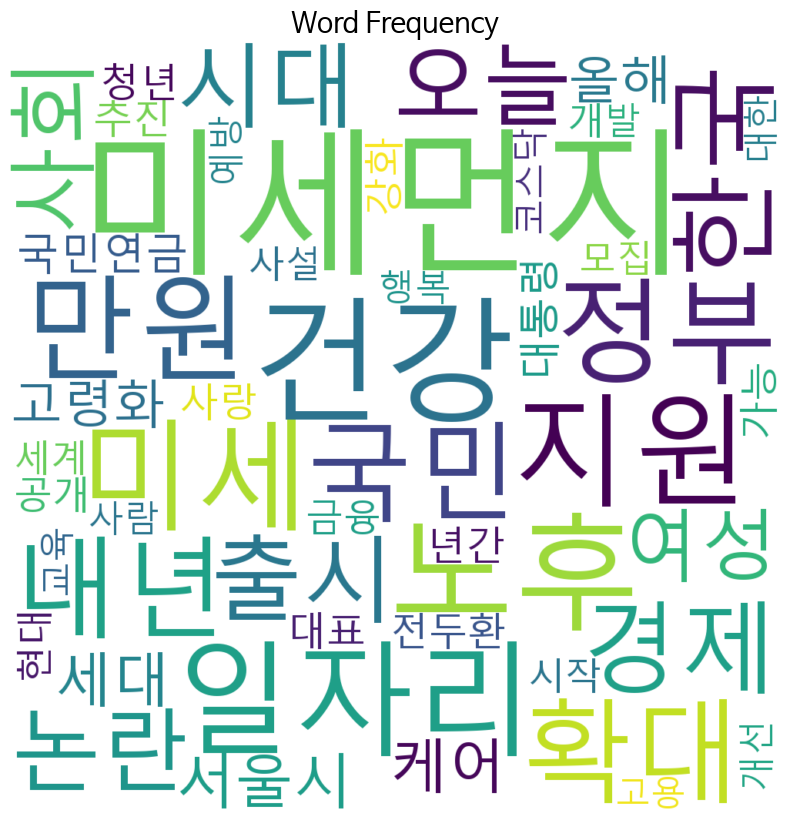

2020
training was done. used memory 6.196 Gbory 6.190 Gb
all cohesion probabilities was computed. # words = 32012
all branching entropies was computed # words = 47771
all accessor variety was computed # words = 47771
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 37549
_noun_scores_ 7997
after postprocessing 5561


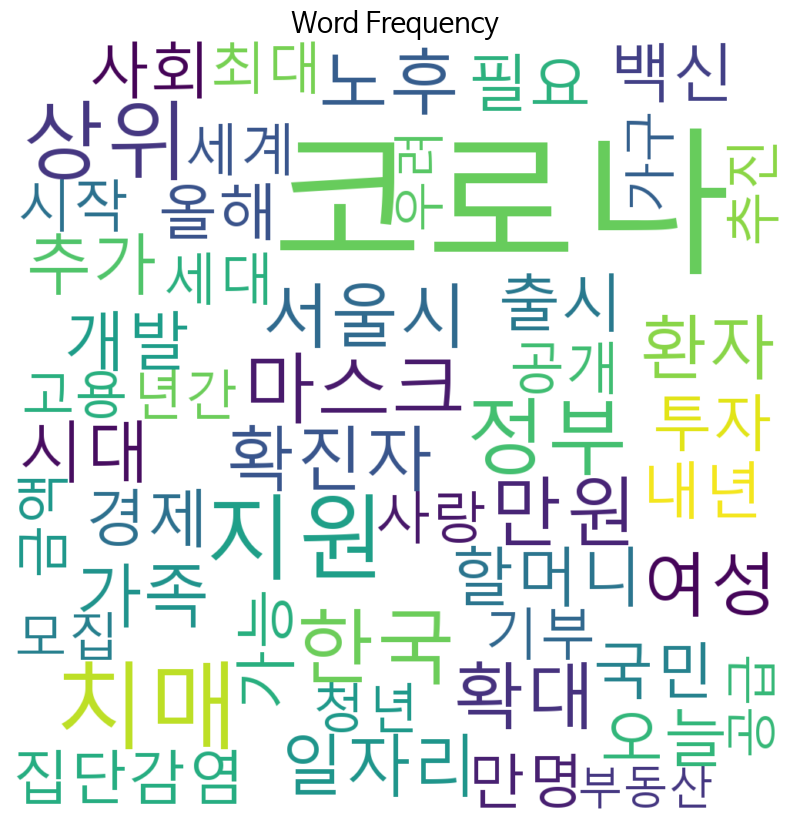

2021
training was done. used memory 6.196 Gbory 6.189 Gb
all cohesion probabilities was computed. # words = 32138
all branching entropies was computed # words = 47556
all accessor variety was computed # words = 47556
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 37765
_noun_scores_ 8171
after postprocessing 5517


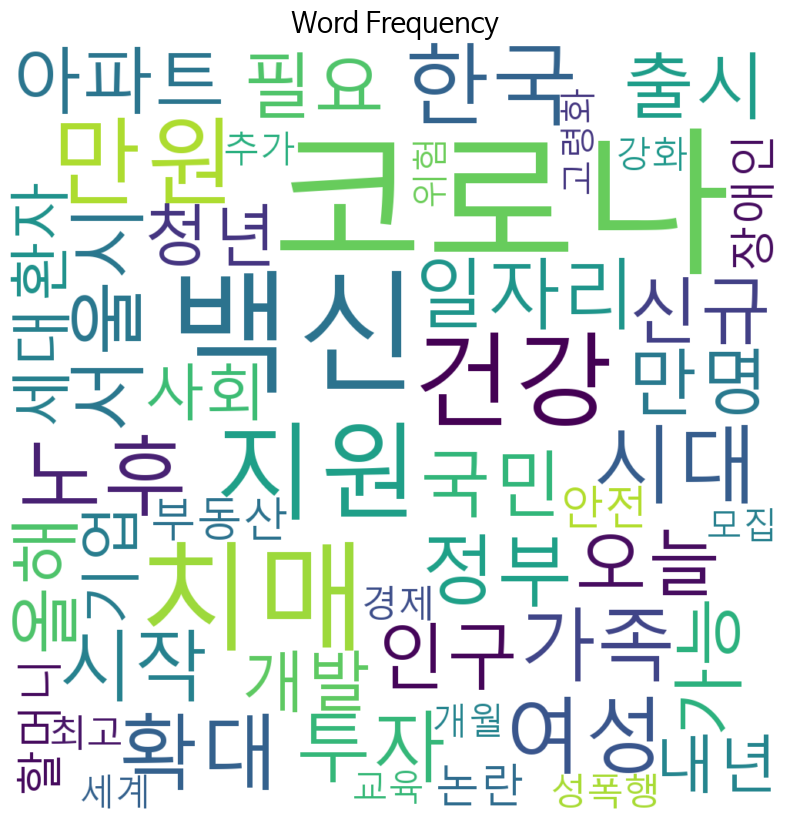

2022
training was done. used memory 6.199 Gbory 6.192 Gb
all cohesion probabilities was computed. # words = 31565
all branching entropies was computed # words = 46768
all accessor variety was computed # words = 46768
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 37236
_noun_scores_ 8030
after postprocessing 5461


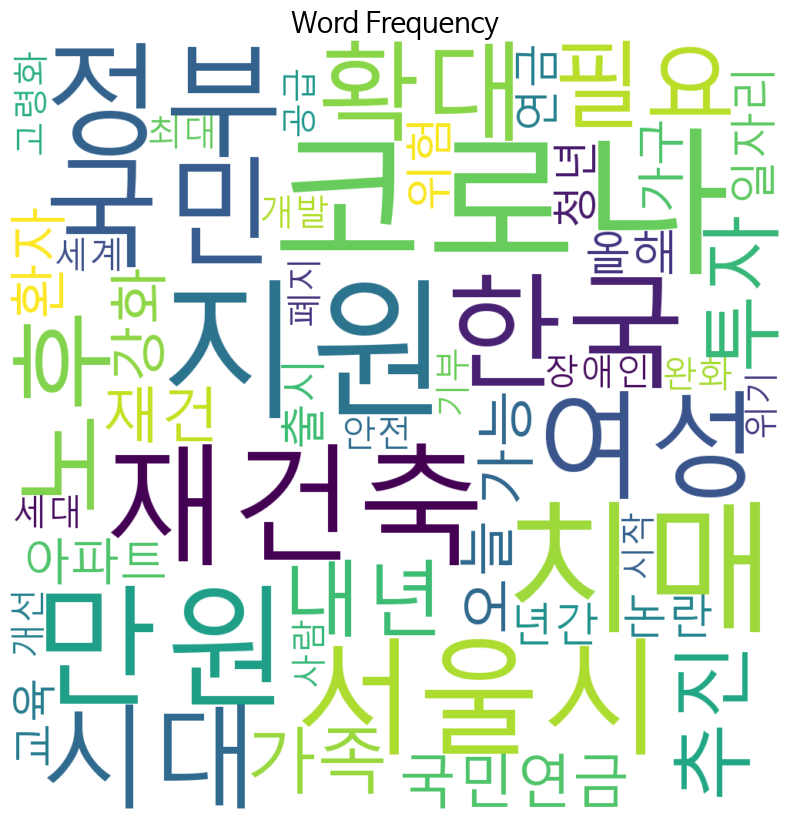

2023
training was done. used memory 6.201 Gbory 6.194 Gb
all cohesion probabilities was computed. # words = 25041
all branching entropies was computed # words = 38486
all accessor variety was computed # words = 38486
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 30072
_noun_scores_ 6514
after postprocessing 4393


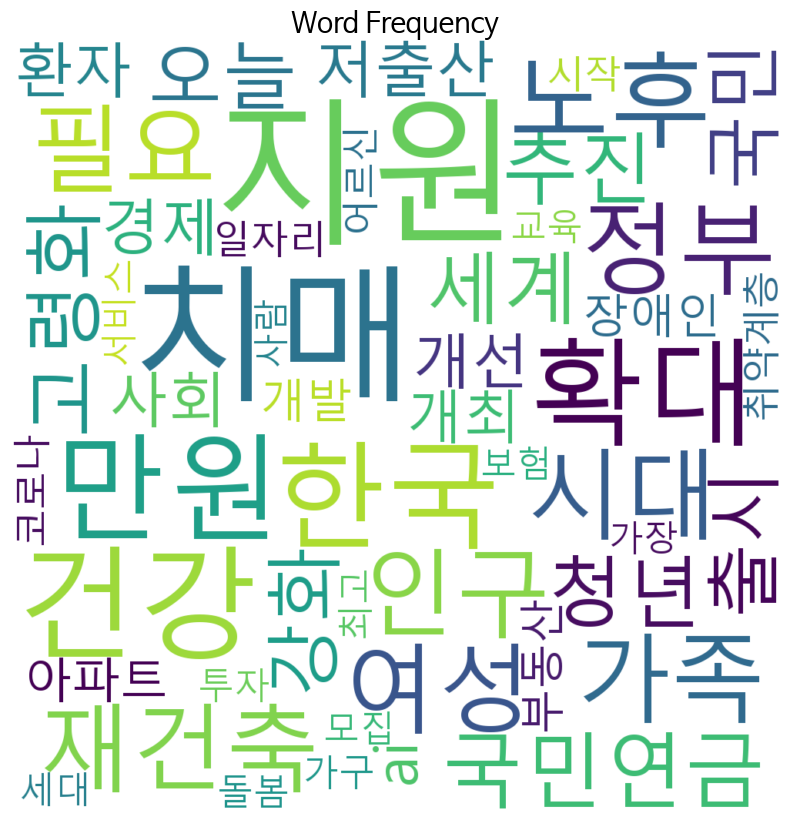

In [46]:
# https://github.com/PrashantSaikia/Wordcloud-in-Plotly
# https://twitter.com/thomas_mock/status/1518729259828797445/photo/3
# https://www.beautiful.ai/templates/word-cloud
# https://app.flourish.studio/templates#template-word-cloud

for year in sorted(df['일자'].dt.year.unique()):
    print(year)
    
    # 데이터 분리
    df_sub = df[df['일자'].dt.year == year]
    
    # 문서 요약
    words_title = preprocessing_nounextract(df_sub['제목'])
    
    # 시각화
    plot_wordcloud(dict(words_title), mask_colorgen=False, max_words=50)

In [4]:
# 하이퍼파라미터
FOLDER_LOCATION = os.path.join(os.getcwd(), 'Data', '빅카인즈', '노인+가족')
IMAGE_LOCATION = 'wordcloud_ageism.png'

# 데이터로딩
df_news = get_data_from_path(FOLDER_LOCATION)
df = df_news.copy()
## 날짜 인식
df = df[df.Date != 'None'].reset_index().iloc[:,1:]
df.Date = pd.to_datetime(df.Date)
## 중복 처리
df.drop_duplicates(inplace=True, ignore_index=True)
## 전처리
df.Category = df.Category.apply(lambda x: text_preprocessor(x, del_bracket_content=False))
df.Title = df.Title.apply(lambda x: text_preprocessor(x, del_bracket_content=True))
df.Content = df.Content.apply(lambda x: text_preprocessor(x, del_bracket_content=False))
display(df.head())

,Date,Press,Category,Title,Content,Comment,URL_Origin,URL_Naver
0,2023-08-31 19:49:21,연합뉴스,세계,내수 활성화 급한 중국 영유아노인 부양비 소득공제 확대,ap연합뉴스 자료사진 베이징연합뉴스 정성조 특파원 경제 회복을 위해 최근 내수 진작 정책을 잇달아 내놓고 있는 중국이 이번에는 영유아노인 부양 관련 소득세 공제 범위...,[],https://www.yna.co.kr/view/AKR20230831171700083?input=1195m,https://n.news.naver.com/mnews/article/001/0014164497?sid=104
1,2023-08-27 06:25:13,한국경제TV언론사 선정,사회,노인빈곤율 위인데연금 정부지출은 압도적 꼴찌,한국은 경제협력개발기구oecd 개국 중 노인빈곤율 위라는 불명예를 쓰고 있지만 정작 이를 해결하기 위한 주요 수단인 공적연금에 투입되는 정부 재정은 oecd 국가 평균의 절...,"['연금에도세금붙이는나라는여기박에없을것', '좁은 땅덩어리에 공항 고속도로는 이제 그만 만들어도 된다..특히 새만금 공항등 지방의 텅텅빈 국도 고속도로 천지인데 이제그만 안...",http://www.wowtv.co.kr/NewsCenter/News/Read?articleId=A202308270013&t=NN,https://n.news.naver.com/mnews/article/215/0001121516?sid=102
2,2023-08-29 11:00:00,뉴스1언론사 선정,경제,내년 인가족 생계급여 만원노인일자리 만개 돌파,예산노인일자리 수당기초연금 동시 수급 시 만원 지원장애인 복지 예산 억 소상공인 예산 조 확대 오후 경기 수원시 팔달구 화성행궁에서 열린 노인 일자리 채용 한마당에서...,"['우리가 하면 착한 노인 일자리 니들이 하면 총선용 포퓰리즘', '노인일자리 싹 사라지더니 선거가 다가오니 다시 늘리네.', '문재인이 하면 포퓰리즘 지가하면 복지 ㅋㅋ ...",https://www.news1.kr/articles/5153792,https://n.news.naver.com/mnews/article/421/0007015697?sid=101
3,2023-08-29 11:00:20,머니투데이언론사 선정,경제,내년 생계급여 최대 만원 인상노인일자리 만명 공급,년도 예산안 내년 기초생활수급자가 받는 생계급여최저생계비가 만원인가구 기준 오른다 생계급여 수급 대상도 만가구 확대된다 노인 일자리는 사상 첫음으로 만개를 넘는다 저소...,"['헐~\n노인일자리 \n노인의 나라\n우짜노 \n우리 젊은이들은 결혼도 늦어져 \n출산율 저조해 \n멀쩡한 노인들 집에 가사지원에 물품지원.기초수급까지', '졸라 노인이고...",http://news.mt.co.kr/mtview.php?no=2023082909484321596,https://n.news.naver.com/mnews/article/008/0004931089?sid=101
4,2023-08-29 11:37:11,SBS Biz언론사 선정,경제,생계급여 만원으로노인 수당청년 교통 할인,앵커내년 예산은 저소득층 노인 장애인 사회적 약자를 위한 복지 강화에도 초점이 맞춰졌습니다저소득층 생계급여를 역대 최대폭으로 인상하고 노인일자리 수당을 확대합니다또 청년들의...,"['저소득보다 중류층도 독고노인들 보살펴라 누구는 안먹고 안쓰고 노후를위해 고생했는대 막살아서 저소득 혜택받고 불공평하지않나 기초연금도 전원지급해라', '저소득층 대학등록금...",https://biz.sbs.co.kr/article_hub/20000133314?division=NAVER,https://n.news.naver.com/mnews/article/374/0000349112?sid=101


2023
training was done. used memory 0.752 Gb
all cohesion probabilities was computed. # words = 315
all branching entropies was computed # words = 957
all accessor variety was computed # words = 957
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 466
_noun_scores_ 92
after postprocessing 48


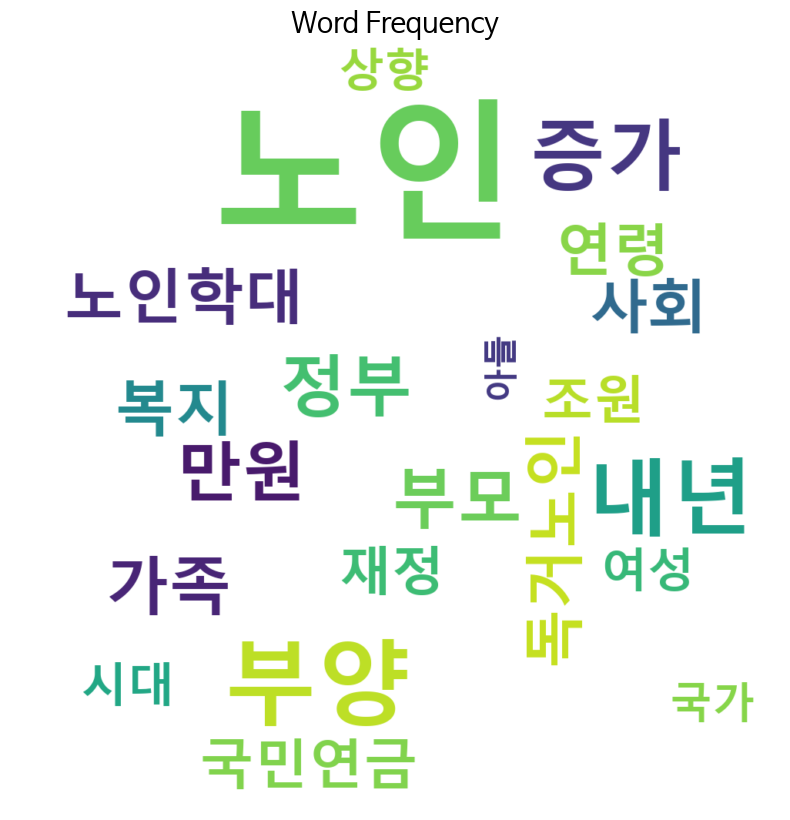

2022
training was done. used memory 0.766 Gb
all cohesion probabilities was computed. # words = 122
all branching entropies was computed # words = 474
all accessor variety was computed # words = 474
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 192
_noun_scores_ 45
after postprocessing 29


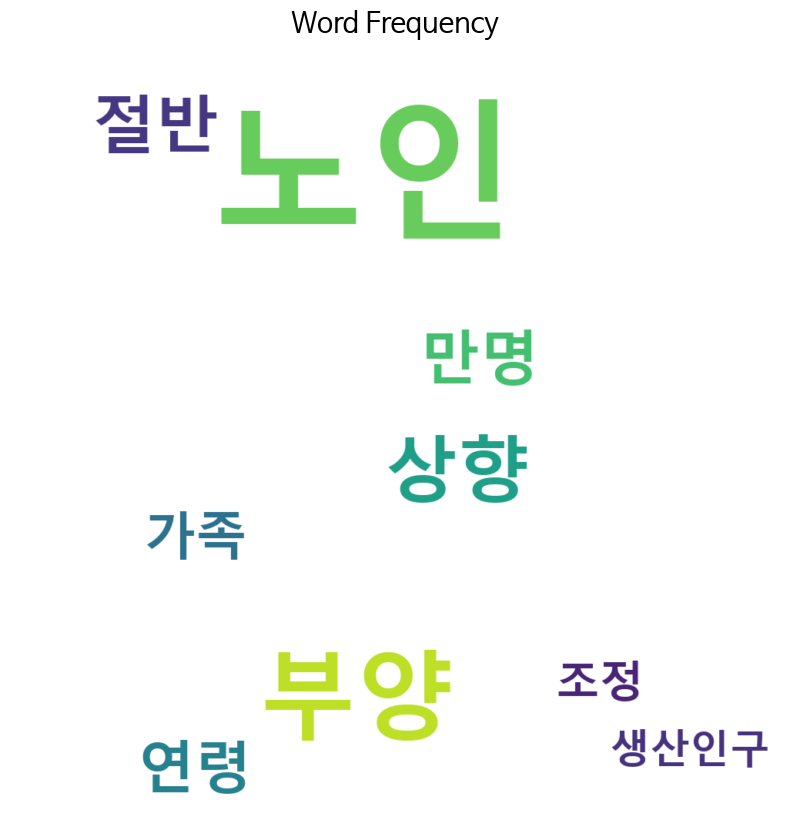

2021
training was done. used memory 0.772 Gb
all cohesion probabilities was computed. # words = 89
all branching entropies was computed # words = 436
all accessor variety was computed # words = 436
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 173
_noun_scores_ 27
after postprocessing 15


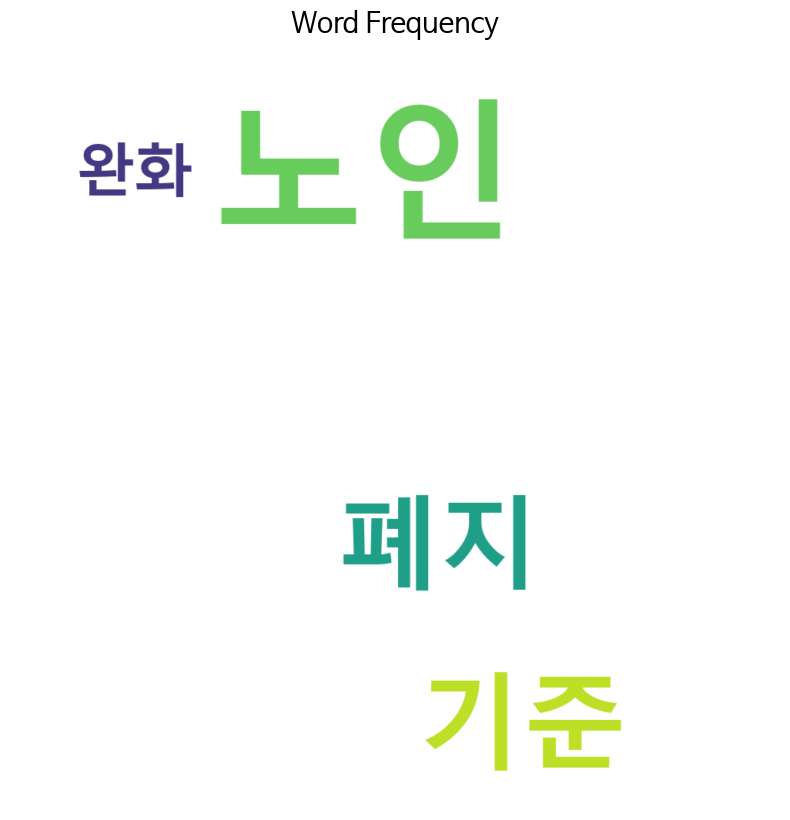

2020
training was done. used memory 0.772 Gb
all cohesion probabilities was computed. # words = 87
all branching entropies was computed # words = 353
all accessor variety was computed # words = 353
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 126
_noun_scores_ 20
after postprocessing 14


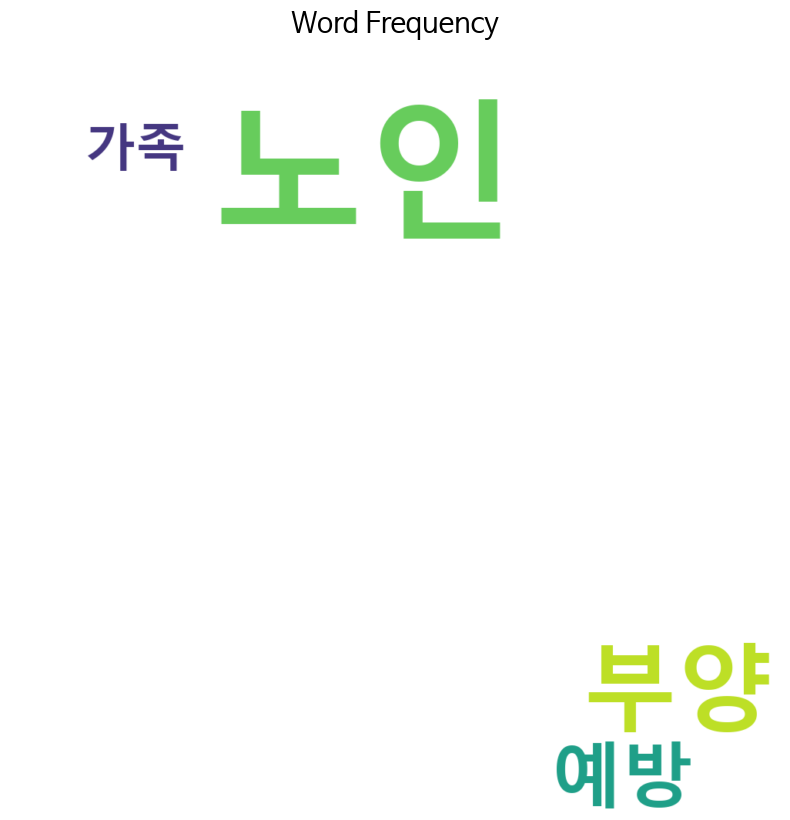

2019
training was done. used memory 0.777 Gb
all cohesion probabilities was computed. # words = 213
all branching entropies was computed # words = 657
all accessor variety was computed # words = 657
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 287
_noun_scores_ 59
after postprocessing 32


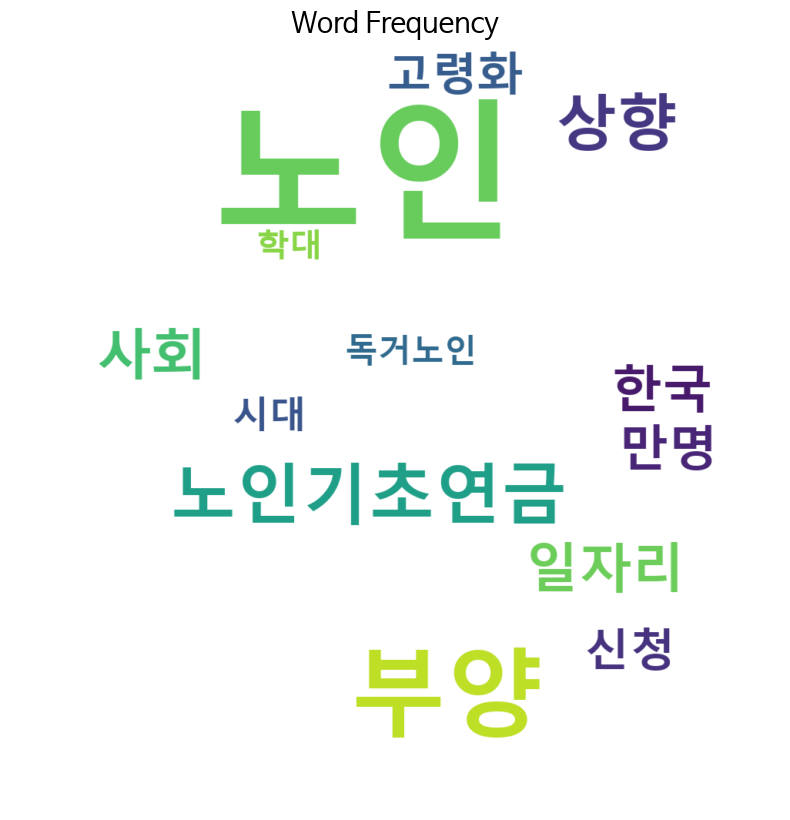

2018
training was done. used memory 0.783 Gb
all cohesion probabilities was computed. # words = 98
all branching entropies was computed # words = 373
all accessor variety was computed # words = 373
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 161
_noun_scores_ 32
after postprocessing 20


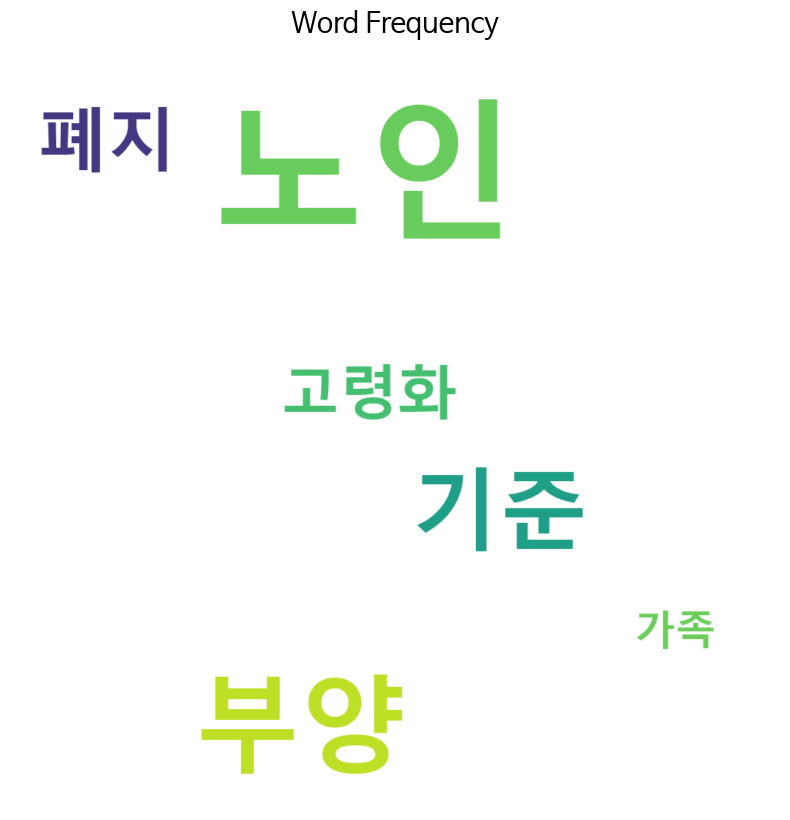

2017
training was done. used memory 0.784 Gb
all cohesion probabilities was computed. # words = 230
all branching entropies was computed # words = 774
all accessor variety was computed # words = 774
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 342
_noun_scores_ 55
after postprocessing 31


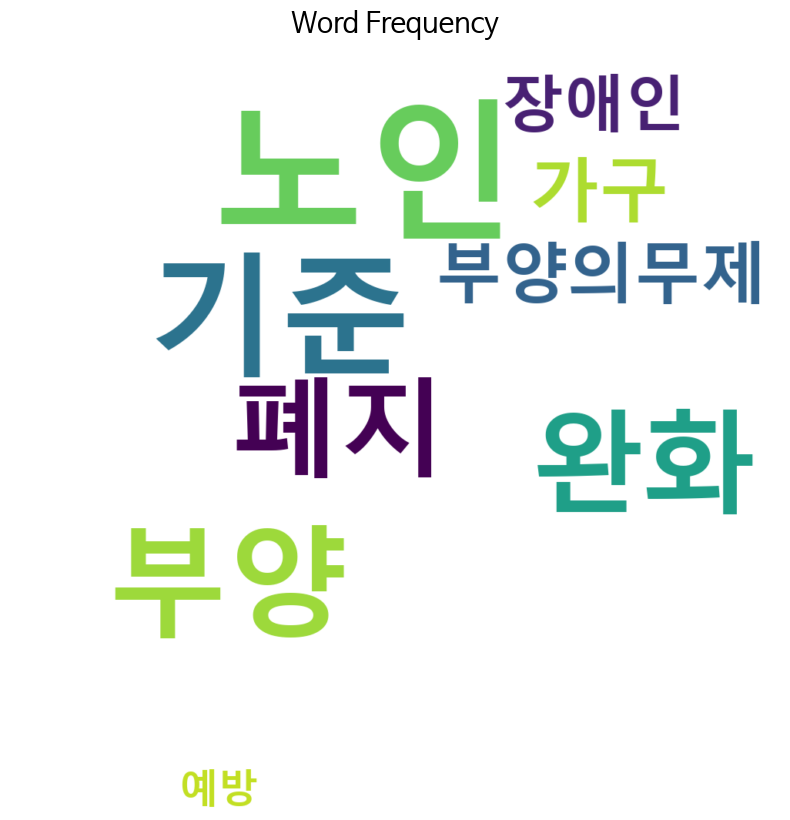

2016
training was done. used memory 0.784 Gb
all cohesion probabilities was computed. # words = 76
all branching entropies was computed # words = 346
all accessor variety was computed # words = 346
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 143
_noun_scores_ 29
after postprocessing 12


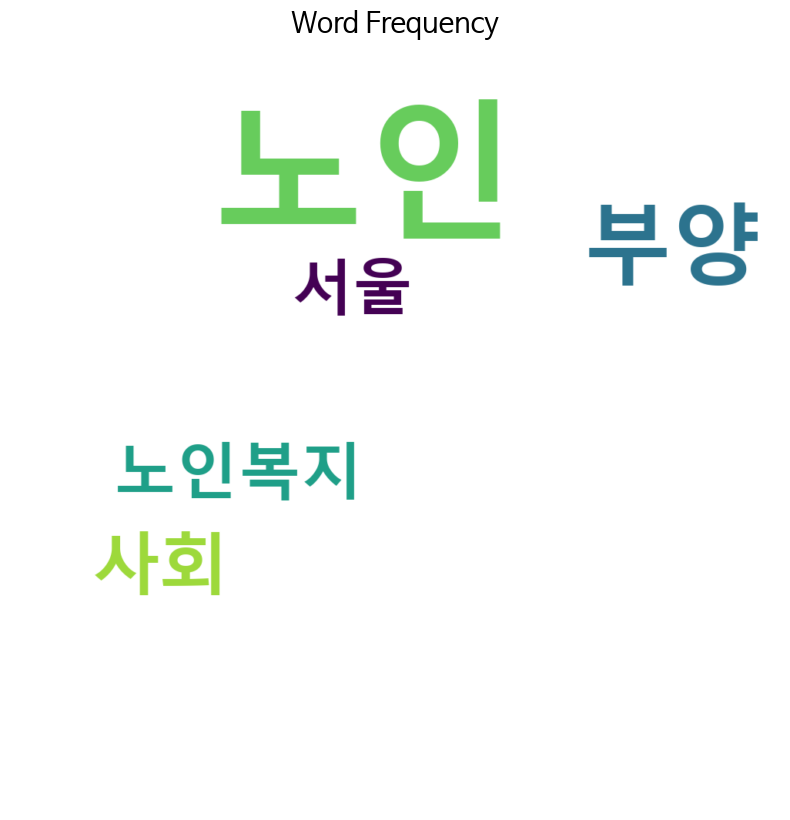

2015
training was done. used memory 0.784 Gb
all cohesion probabilities was computed. # words = 91
all branching entropies was computed # words = 487
all accessor variety was computed # words = 487
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 186
_noun_scores_ 43
after postprocessing 27


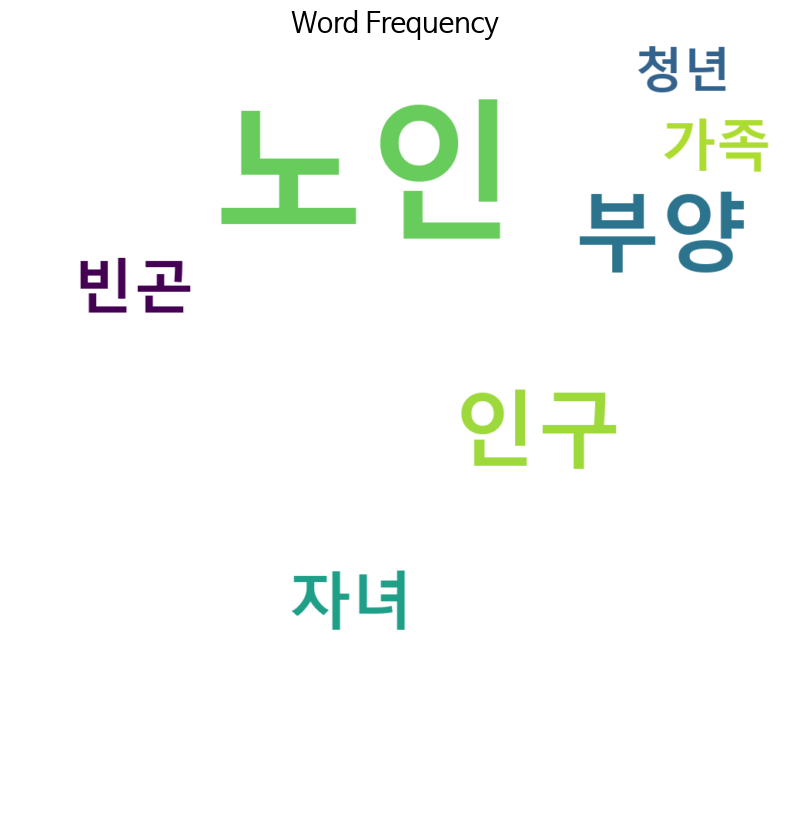

2014
training was done. used memory 0.784 Gb
all cohesion probabilities was computed. # words = 79
all branching entropies was computed # words = 330
all accessor variety was computed # words = 330
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 135
_noun_scores_ 21
after postprocessing 13


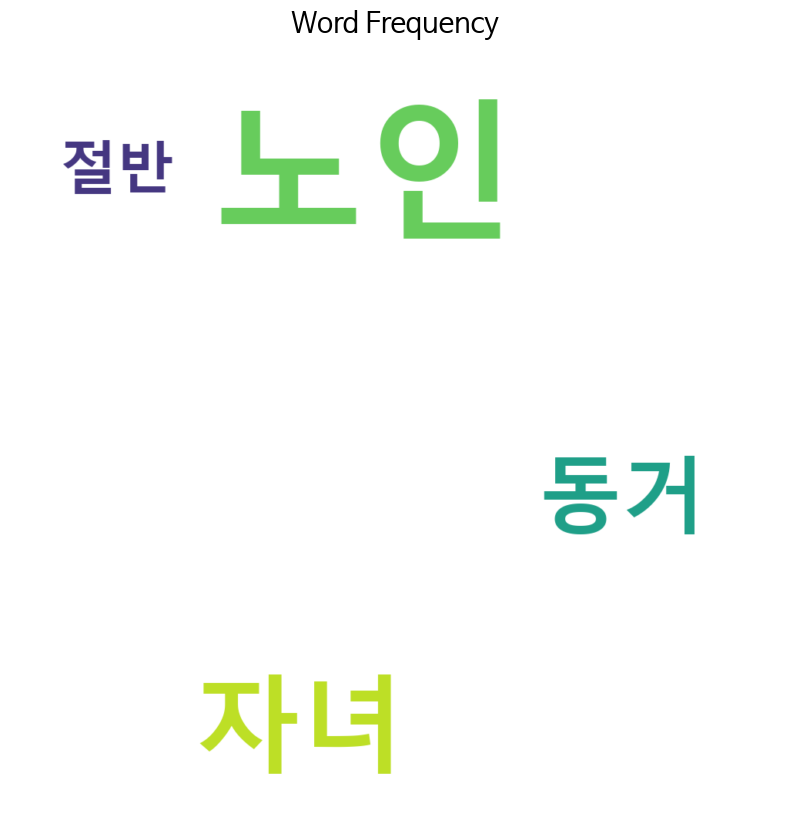

2013
training was done. used memory 0.784 Gby 0.784 Gb
all cohesion probabilities was computed. # words = 33
all branching entropies was computed # words = 191
all accessor variety was computed # words = 191
C:/Users/KK/anaconda3/Lib/site-packages/soynlp
cannot access local variable 'f' where it is not associated with a value
cannot access local variable 'f' where it is not associated with a value
before postprocessing 94
_noun_scores_ 18
after postprocessing 9


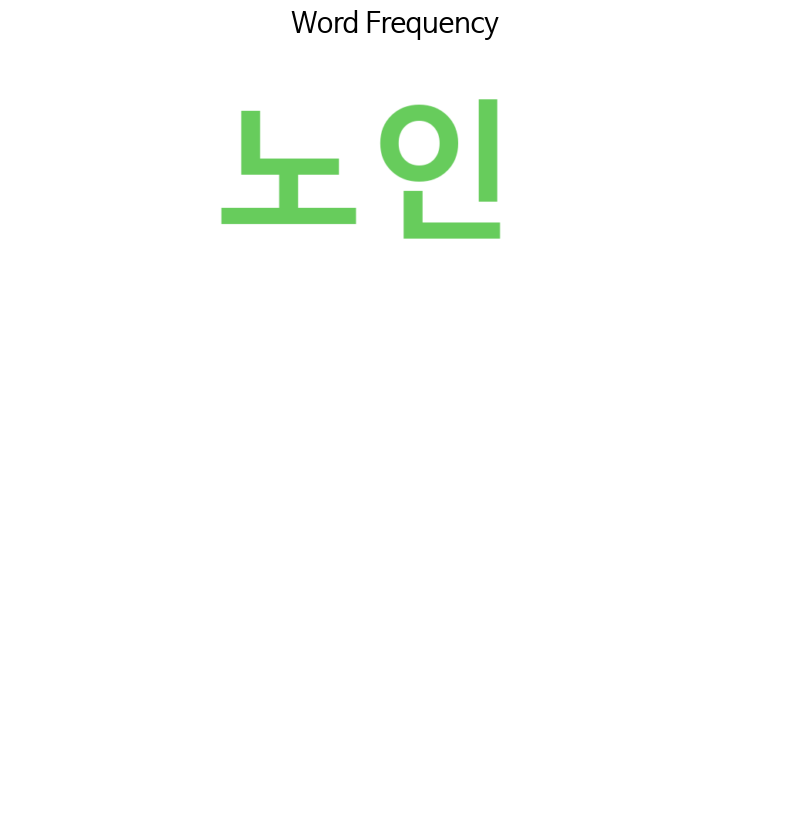

In [6]:
# https://github.com/PrashantSaikia/Wordcloud-in-Plotly
# https://twitter.com/thomas_mock/status/1518729259828797445/photo/3
# https://www.beautiful.ai/templates/word-cloud
# https://app.flourish.studio/templates#template-word-cloud

for year in list(df.Date.dt.year.unique()):
    print(year)
    
    # 데이터 분리
    df_sub = df[df.Date.dt.year == year]
    
    # 문서 요약
    words_title = preprocessing_nounextract(df_sub.Title)
    
    # 시각화
    plot_wordcloud(dict(words_title), mask_colorgen=False)